# Binary phenotype Chunk single cell analysis tutorial

In this tutorial, you can learn how to perform a single-cell Chunk analysis to identify binary phenotype-associated LRI.

As input, you need single-cell transcriptomic data, bulk expression matrices, and binary phenotypic annotations of bulk samples.

As an example, we will use a set of COVID-19 scRNA-seq data and a set of bulk RNA-seq data from a COVID-19 patient cohort, along with their corresponding phenotypic labels, to perform Chunk analysis and identify COVID-19 phenotypes-associated CCI.

See our manuscript for more details.

## Import

In [1]:
import Chunk
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Loading Bulk data and Data processing

First, we load the bulk data from COVID-19 and its corresponding clinical meta-data. Note that the expression matrix we load should have samples as columns and genes as rows, while the clinical meta-file should have samples as rows and clinical information as columns.

In [2]:
expr_df = pd.read_csv('data/COVID_19.csv', header=0, index_col=0).T 
clin_df = pd.read_csv('data/COVID_19_metadata.csv',index_col = 2)


Next, we use Chunk to filter the bulk expression matrix: We select genes that express ligands and receptors, and filter out genes with an average expression level below 1 (log2(tpm+1)). Chunk uses the ligand-receptor database from SingleCellSignalR by default.


In [3]:
lr_expr_pairs, lr_expr_df = Chunk.filter_Bulkdata(expr_df,threshold=1)

**Note:** Of course, you can provide Chunk with a customized ligand-receptor database according to your needs, and choose whether to filter out lowly expressed genes. The ligand-receptor database you provide should be in CSV format and must have two columns named "ligand" and "receptor".

In [ ]:
lr_expr_pairs, lr_expr_df = Chunk.filter_Bulkdata(bulk_data = expr_df,lr_db_path = "Human-2020-Cabello-Aguilar-LR-pairs.csv")

Next, we process the meta data to obtain the phenotypic constraints and other relevant information required for Chunk analysis. Here, S is the phenotypic constraint used by Chunk to identify LRI, and Y is the phenotypic constraint used to identify CCI. Additionally, the sorted ligand-receptor expression matrix, sorted clinical meta-information, and sample location information will be returned for subsequent analysis.

In [4]:
clin_df = clin_df.loc[lr_expr_df.columns] #Remove the patients not present in the bulk cohort from the clin_df
S, Y, lr_expr_df, phenotype_interval, sorted_clin_df = Chunk.getBinaryConstraint(
    clin_df=clin_df,
    lr_expr_df=lr_expr_df,
    by='COVID', #The column names of the phenotypes we focused in clin_df
    phenotype_of_interest=1 #The phenotype we concerned in the COVID column
)

## Building Communication Potential Matrix

In [5]:
comm_matrix2 = Chunk.build_communication_matrix(lr_expr_pairs, lr_expr_df)

## identify phenotype-associated LRIs

Before performing phenotype-associated LRI analysis using Chunk, we need to estimate the number of potential biological patterns in this bulk cohort using the elbow method. Users can control the number of identified potential biological patterns by adjusting the elbow point (eii_tol). Chunk defaults to an eii_tol value of 0.05.

In [6]:
optimal_K = Chunk.select_k_nmf(
    comm_matrix2.T.values.astype(float), S, k_max=20, repeat_times=5, verbose=True, eii_tol = 0.05,
    use_semi_supervised=True,
    semi_supervised_params={"alpha": 0.01, "beta": 0.01, "rho": 0.75}
)

K=2, Reconstruction Error=29855.4492
K=3, Reconstruction Error=24154.4961
K=4, Reconstruction Error=21355.1375
K=4, eii=0.3293
K=5, Reconstruction Error=19283.8488
K=5, eii=0.1959
K=6, Reconstruction Error=17410.2320
K=6, eii=0.1505
K=7, Reconstruction Error=15926.1332
K=7, eii=0.1065
K=8, Reconstruction Error=14761.1652
K=8, eii=0.0772
K=9, Reconstruction Error=13702.4404
K=9, eii=0.0655
K=10, Reconstruction Error=12676.2309
K=10, eii=0.0597
K=11, Reconstruction Error=11844.8371
K=11, eii=0.0462


Then, we execute Chunk to perform phenotype-guided decomposition of the cell communication potential matrix to identify specific communication patterns.

In [7]:
W, H, loss_history = Chunk.LRcommMining(X = comm_matrix2.T.values.astype(float), S=S, n_components=optimal_K, alpha=0.01, beta=0.01, rho=0.75, maxiter=8000, lr=0.001)

Iteration 0/8000, Loss: 12673.2773
Iteration 50/8000, Loss: 12614.2334
Iteration 100/8000, Loss: 12564.3008
Iteration 150/8000, Loss: 12524.2461
Iteration 200/8000, Loss: 12491.3311
Iteration 250/8000, Loss: 12463.6494
Iteration 300/8000, Loss: 12440.2148
Iteration 350/8000, Loss: 12420.2305
Iteration 400/8000, Loss: 12402.9844
Iteration 450/8000, Loss: 12387.9541
Iteration 500/8000, Loss: 12374.7197
Iteration 550/8000, Loss: 12363.0332
Iteration 600/8000, Loss: 12352.7158
Iteration 650/8000, Loss: 12343.4541
Iteration 700/8000, Loss: 12335.0273
Iteration 750/8000, Loss: 12327.3545
Iteration 800/8000, Loss: 12320.3027
Iteration 850/8000, Loss: 12313.7832
Iteration 900/8000, Loss: 12307.7705
Iteration 950/8000, Loss: 12302.1660
Iteration 1000/8000, Loss: 12296.8984
Iteration 1050/8000, Loss: 12291.9385
Iteration 1100/8000, Loss: 12287.2852
Iteration 1150/8000, Loss: 12282.8584
Iteration 1200/8000, Loss: 12278.6602
Iteration 1250/8000, Loss: 12274.7178
Iteration 1300/8000, Loss: 12270.90

We visualize the distribution of pattern scores for each communication pattern obtained from the Chunk.  


**Note:** Here, phenotype_interval is a dictionary that internally stores the sorted sample location information, with samples of the same phenotype clustered together. The label represents the phenotype type corresponding to the samples within the phenotype_interval range.

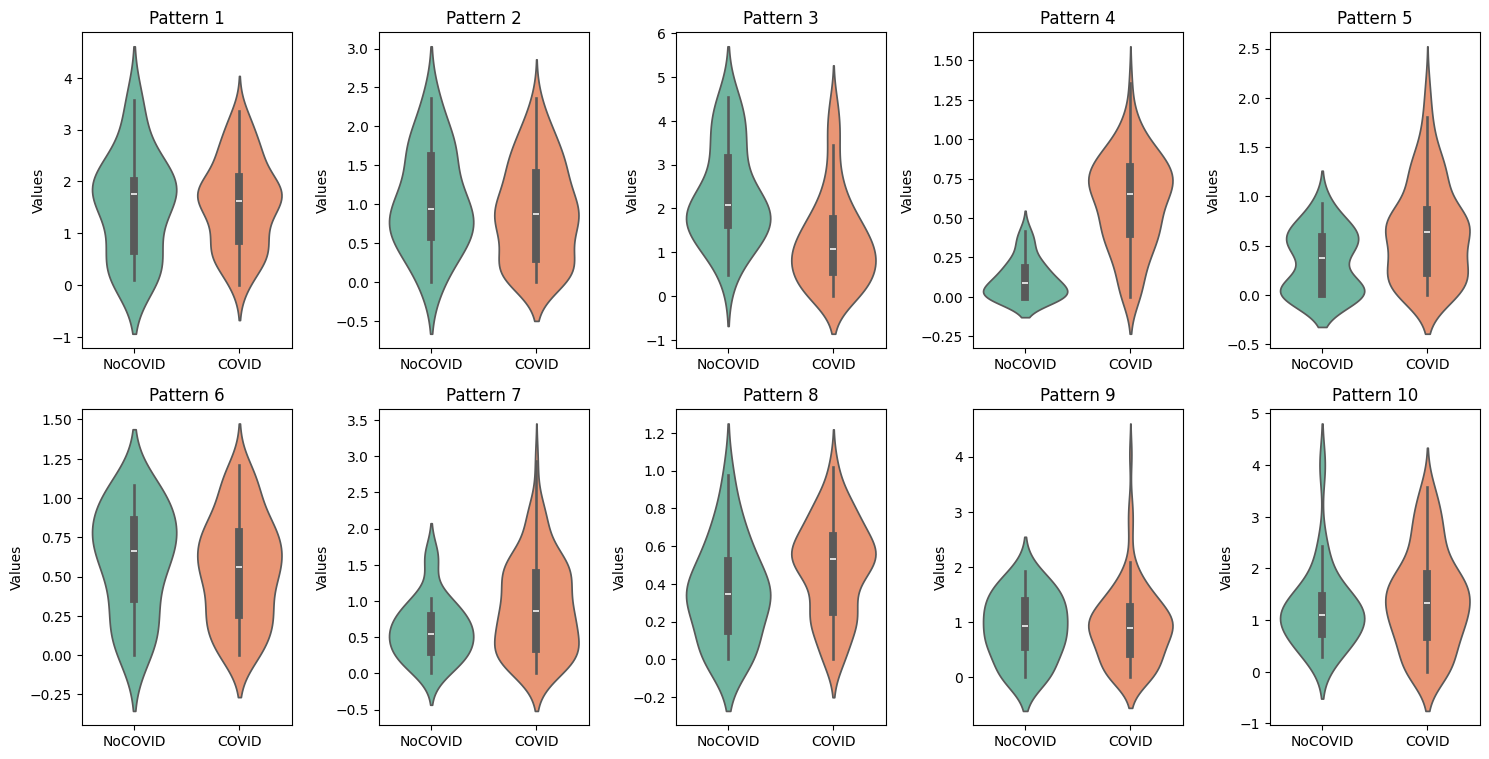

In [8]:
Chunk.getPatternDistribution(W, labels=['NoCOVID', 'COVID'], phenotype_interval = phenotype_interval)

Using the association analysis provided by Chunk, we can evaluate which patterns are more relevant to the phenotypes of interest. 

**Note:** It is important to note that the association analysis provided by Chunk requires that the phenotype column in the input, i.e., the clinical meta-data, must be a numerical variable. Therefore, we recommend that users convert phenotypes to numerical values in the clinical meta-data in advance. For example, 'COVID' can be converted to 1, and 'non-COVID' can be converted to 0. Finally, Chunk considers a positive correlation to be more related to phenotypes with higher numerical values (in this example, it would be 1, which corresponds to 'COVID').



In [9]:
phenotype_types = {
    "COVID": "binary", #The column name of the phenotype in sorted_clin_df: The type of the phenotype ("binary","continuous","ordinal")
}

result = Chunk.Singleassociationanalysis(W, sorted_clin_df, phenotype_types)

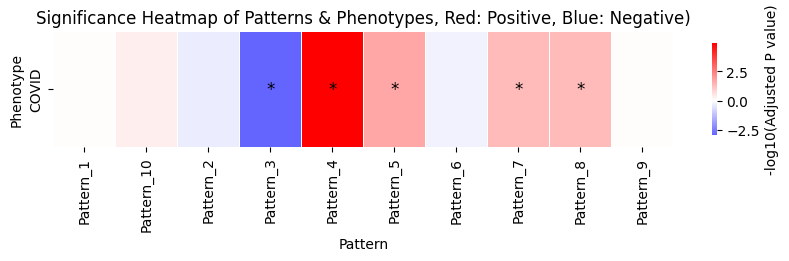

In [10]:
Chunk.plot_significance_heatmap(result, alpha = 0.05)

Patterns 4, 5, 7, and 8 are significantly more associated with the COVID phenotype. To further investigate, we extract the top LRIs (Ligand-Receptor Interactions) from these patterns. Here, we set the threshold to 2.5 (the default threshold in Chunk is 2) and visualize the results.

**Note:** We recommend users to identify phenotype-specific patterns by combining Chunk's association analysis with visualization results.

In [11]:
res = Chunk.getLRcomm(W,H,comm_matrix2,patterns = [4,5,7,8], lr_expr_pairs = lr_expr_pairs,zscore_threshold = 2.5)

In [12]:
Chunk.plot_sankey(res, width=600, height=1100,thickness=80,font_size=11)

## Loading scRNA-seq data and Data processing

Guided by the phenotypic information, Chunk will project these LRIs into single-cell or spatial transcriptomic contexts to uncover how they manifest as specific cell–cell communication events within the tissue context.

In [13]:
adata = sc.read_h5ad("data/COVID_19_sc.h5ad")#We recommend that users normalize their data using log(TPM+1) transformation. The original data has already been normalized using log(TPM+1).

To perform single-cell analysis with Chunk, we need to calculate the cell adjacency matrix to constrain the analysis. Scanpy provides the **sc.pp.neighbors** function to compute the similarity matrix stored in **adata.obsp['connectivities']**. After computing **adata.obsp['connectivities']**, we can use Chunk to convert it into a cell adjacency matrix.

In [ ]:
cell_adj = Chunk.similarity2adjacent(adata, key='connectivities')

since the original data provides **adata.obsm['X_pca']**, we can also directly use it to calculate the cell adjacency matrix.


In [14]:
from sklearn.neighbors import kneighbors_graph
cell_adj = kneighbors_graph(adata.obsm['X_pca'], n_neighbors=20, mode='connectivity')

Filtering the genes in the scRNA-seq data based on the phenotype-associated Ligand-Receptor genes identified by Chunk, we obtain the ligand-receptor expression vectors for each cell. We then calculate the pairwise correlation with the ligand-receptor expression vectors of the bulk samples.

In [15]:
sc_lr_expr_df, sc_lr_expr_pairs = Chunk.filter_scRNAdata(res, adata, label = 'cell_type_coarse')#The label is preferably an attribute in adata.obs that identifies cell types. If not available, any other attribute can be specified (the choice of label does not affect the results).
print("Expression matrix shape:", sc_lr_expr_df.shape)
X = Chunk.calculate_correlation_matrix(lr_expr_df, sc_lr_expr_df)

Expression matrix shape: (56, 44721)
|**************************************************|
Performing quality-check for the correlations
The five-number summary of correlations:
Min: -0.16660225339930135
25th Percentile: 0.7225927464785202
Median: 0.7820252323175043
75th Percentile: 0.8272528669253051
Max: 0.9846695591973221
|**************************************************|


## Identify phenotype-associated CCI active regions

Chunk will select different regression models for optimization based on the different phenotype type (method = 'binary' or 'linear' or 'cox' or 'ordinal').

In [16]:
CCcomm = Chunk.CCcommInfer(method='binary',X = X, y = Y, alpha=0, lambda_=0.01, Omega=cell_adj, learning_rate=0.0001, n_epochs=1000)

Epoch [100/1000], Loss: 0.5772
Epoch [200/1000], Loss: 0.5626
Epoch [300/1000], Loss: 0.5537
Epoch [400/1000], Loss: 0.5460
Epoch [500/1000], Loss: 0.5381
Epoch [600/1000], Loss: 0.5293
Epoch [700/1000], Loss: 0.5184
Epoch [800/1000], Loss: 0.5040
Epoch [900/1000], Loss: 0.4841
Epoch [1000/1000], Loss: 0.4561


Based on the optimization results from Chunk, we extract the subset of cells with the highest influence weights as phenotype-associated CCI active cells for subsequent analysis (Chunk defaults to the top 40% positive weights).

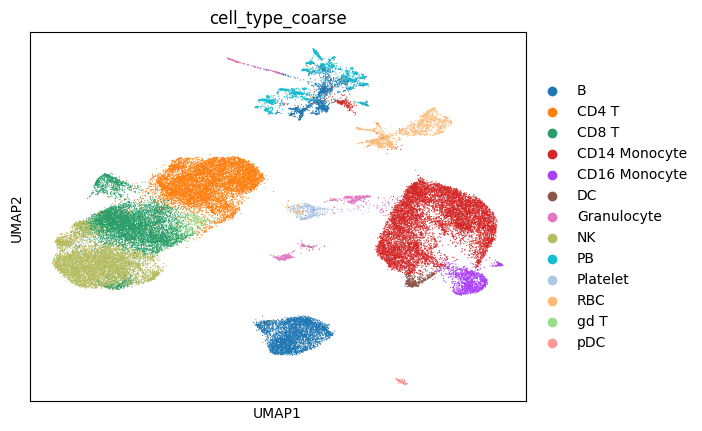

In [17]:
sc.pl.umap(adata, color='cell_type_coarse')

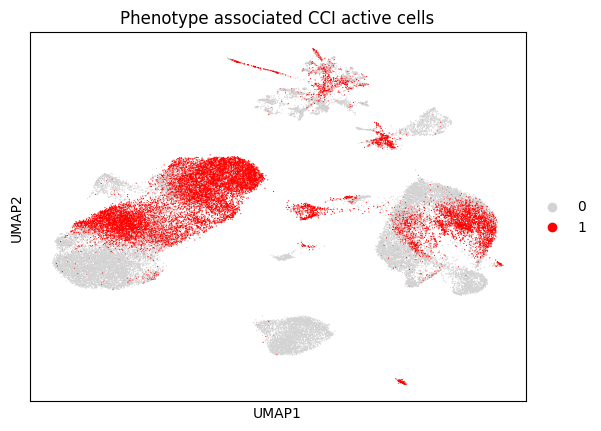

In [18]:
Chunk.getPosipotentialCCI(adata, CCcomm.model, threshold_percent=60) #The 40%(100-60) of cells with the strongest positive correlation with COVID-19.
#In some cases, Chunk also provides a method to extract phenotype-associated CCI active cells with negative correlations to phenotype
#Chunk.getNegapotentialCCI(adata, CCcomm.model, threshold_percent=40) #The 40% of cells with the strongest negative correlation with COVID-19.

After running the Chunk.getPosipotentialCCI (or getNegapotentialCCI) method, the adata.obs will gain a new attribute called 'phe_cell' ('negative_phe_cell' for negative correlations). Cells marked with a value of 1 are identified as phenotype-associated CCI active cells.

    
Chunk can visualize the cells with the top highly expressed ligand-receptor genes among these active cells.

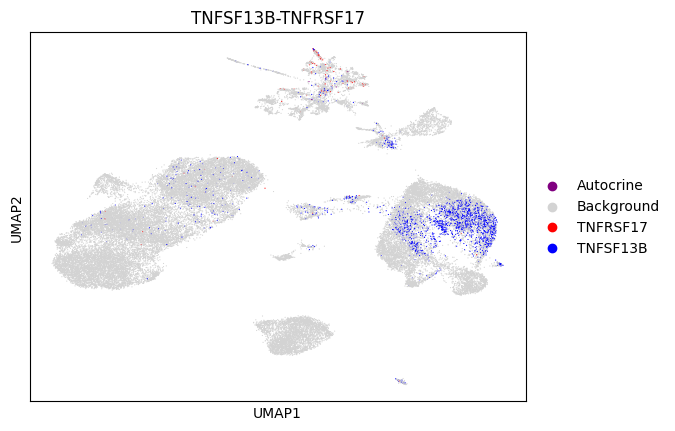

In [19]:
Chunk.getCCcomm(adata, 'TNFSF13B', 'TNFRSF17', L_threshold=5, R_threshold=5, marked_col='phe_cell')#top 5% high expression

Chunk provides a method for detecting phenotype-associated CCI activities in single-cell data, similar to the approaches used by CellPhoneDB and CellChat.


First, we extract the phenotype-associated CCI active cells. You can customize the cell types (interestcell) for your study based on the results from running Chunk.getPosipotentialCCI (or getNegapotentialCCI) or according to your specific research question.

In [20]:
adata1 = adata[adata.obs['phe_cell'] == '1', :].copy()
adata1 = adata1[~adata1.obs['cell_type_coarse'].isna(),:]
Allcell = np.unique(adata1.obs['cell_type_coarse'].values).tolist()
interestcell = ['B', 'CD14 Monocyte', 'CD4 T', 'CD8 T', 'Granulocyte', 'PB', 'Platelet', 'RBC', 'gd T', 'pDC']

In [21]:
pvalues, means, significant_means = Chunk.CCIdetect(
        adata=adata1,
        celltype_key='cell_type_coarse',
        interactions=res,
        iterations=1000,
        senders=interestcell,
        receivers=interestcell
    )

Running randomization analysis: 100%|██████████████████████████████████████████████| 1000/1000 [00:55<00:00, 17.98it/s]


**visualizing the results from Chunk.CCIdetect**

We visualize the number of phenotype-associated CCIs occurring between different cell types, which can intuitively show which cells are the main participants.

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 432.39075944846013
Plotting legends..
Estimated legend width: 14.465277777777779 mm


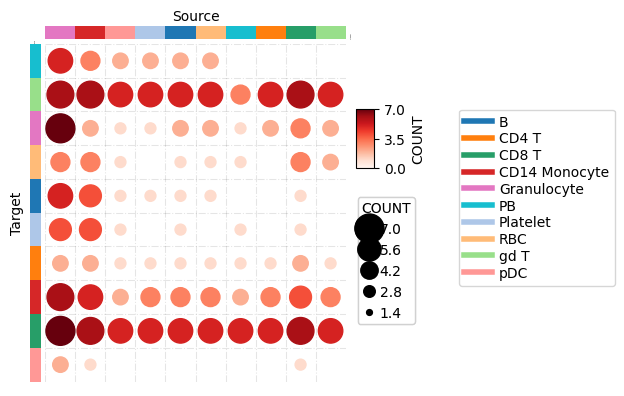

In [22]:
interaction_edges = Chunk.extract_interaction_edges(pvalues, alpha=0.05)
fig, ax = plt.subplots(figsize=(4,4)) 
Chunk.cci_heatmap(adata1[adata1.obs['cell_type_coarse'].isin(interestcell),:],interaction_edges,celltype_key='cell_type_coarse',
                   fontsize=10,target_cells = interestcell, source_cells = interestcell,
          ax=ax,legend_kws={'fontsize':10,'bbox_to_anchor':(5, -0.5),'loc':'center left',})
plt.show()

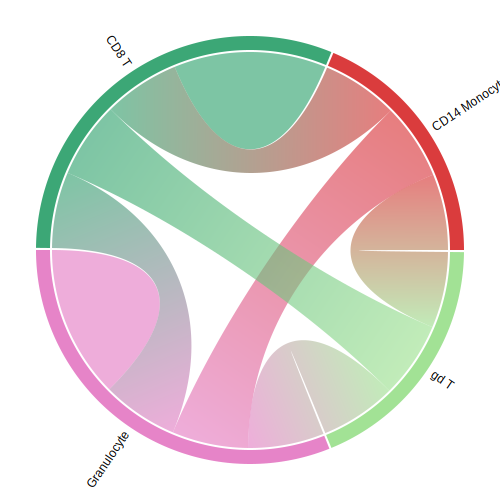

In [23]:
fig=Chunk.cci_chord(adata1,interaction_edges,celltype_key='cell_type_coarse',
          count_min=5,fontsize=12,padding=50,radius=200,save=None,) #count_min: Only shows CCI mediated by more than five specific ligand-receptor types
fig.show()

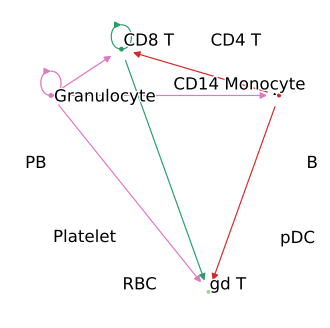

In [24]:
fig, ax = plt.subplots(figsize=(4,4)) 
Chunk.cci_network(adata1,interaction_edges,celltype_key='cell_type_coarse',
             counts_min=5,
            nodesize_scale=5,
                  ax=ax)
plt.show()

We can visualize exactly which phenotypic-related CCI activities occur among specific cell types

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 336.47245978343176
Plotting legends..
Estimated legend width: 32.80972222222222 mm


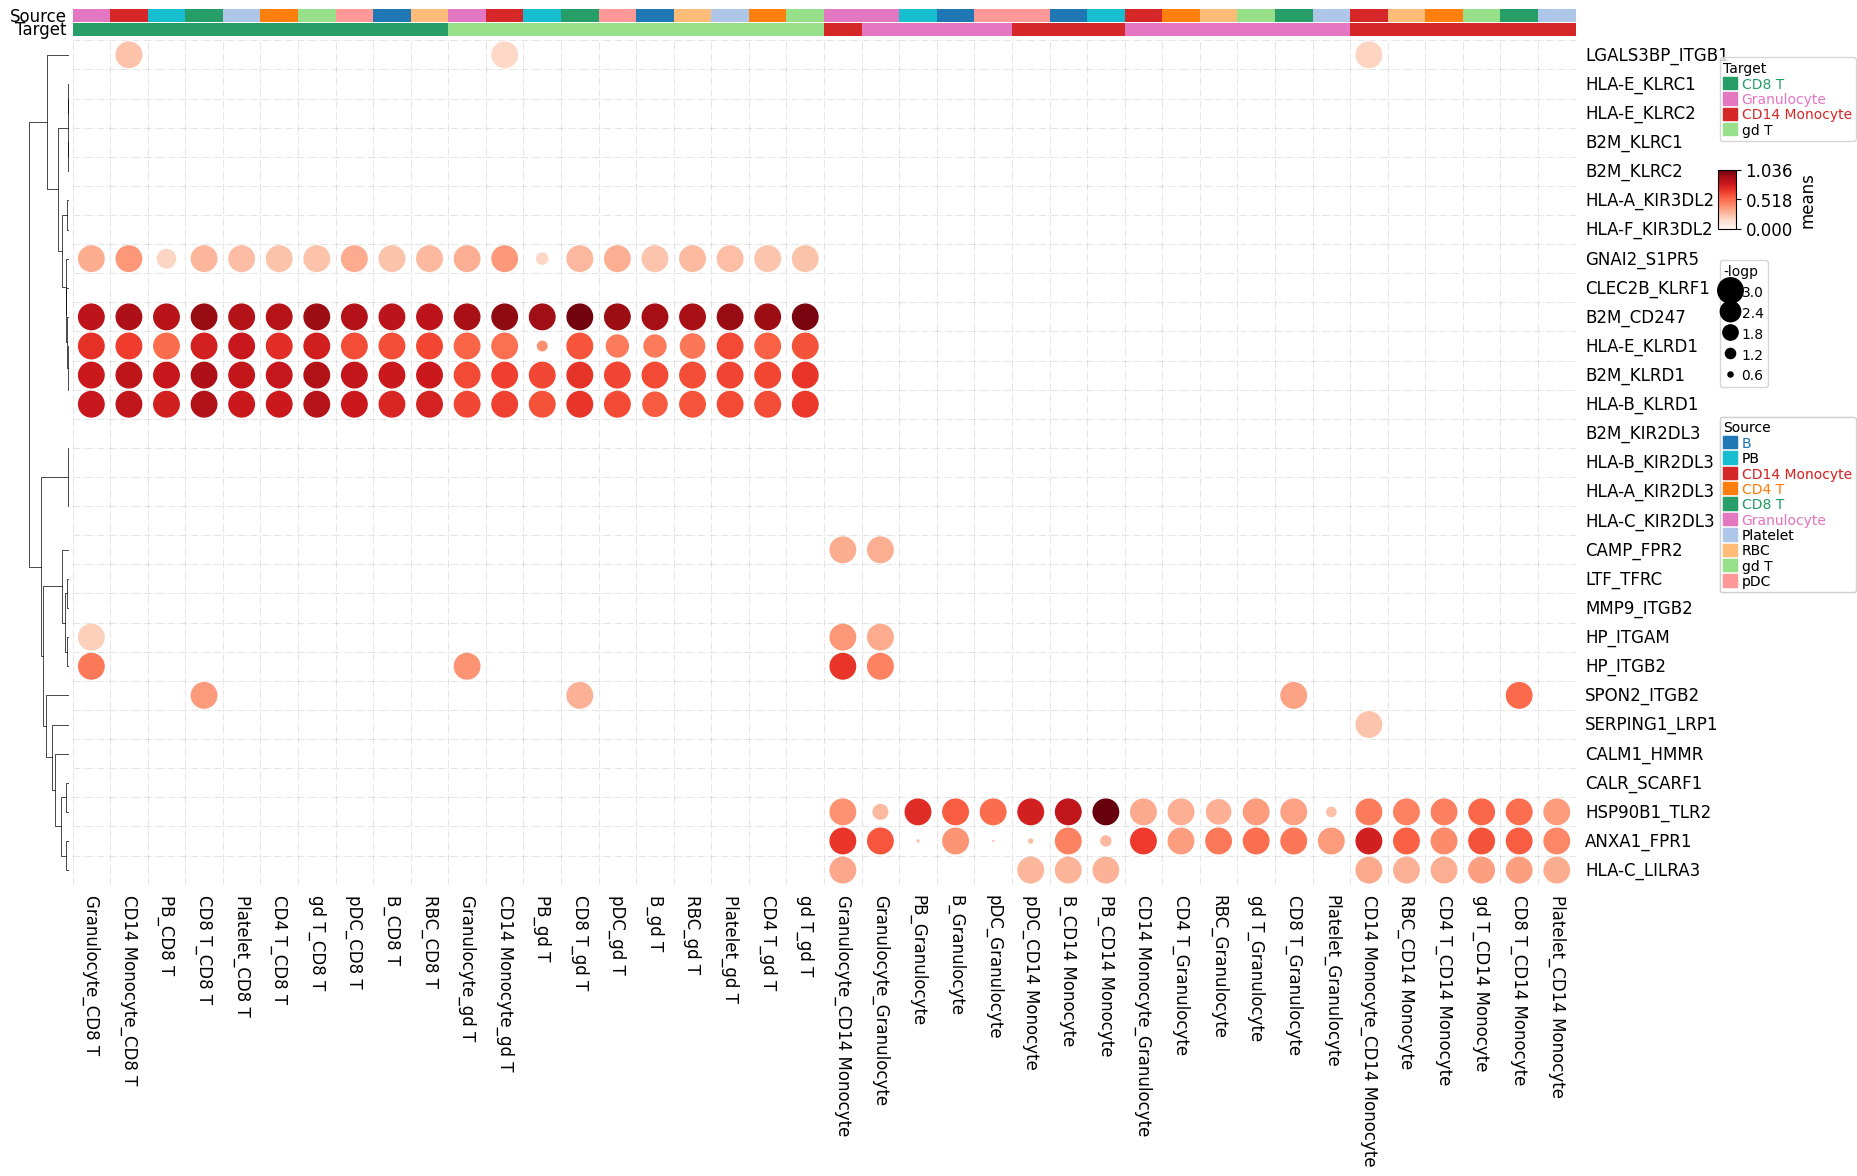

In [25]:
source_cells=interestcell
target_cells=['CD8 T', 'Granulocyte', 'CD14 Monocyte', 'gd T']
Chunk.cci_interacting_heatmap(adata=adata1,
                            celltype_key='cell_type_coarse',
                            means=means, 
                            pvalues=pvalues, 
                            source_cells=source_cells,
                            target_cells=target_cells,
                            min_means=1,
                            nodecolor_dict=None,
                            ax=None,
                            figsize=(20,10),
                            fontsize=12,)
plt.show()

Visualize the CCI network of phenotype-associated CCIs for specific cell types.

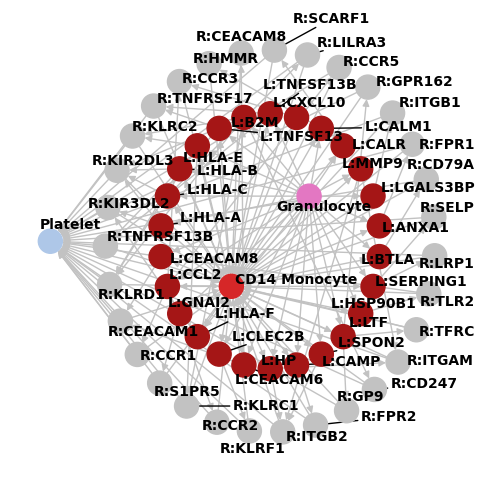

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
Chunk.cci_interacting_network(adata=adata1,
                         celltype_key='cell_type_coarse',
                            means=means,
                            source_cells=['Granulocyte','CD14 Monocyte'],
                            target_cells=['Platelet','CD14 Monocyte'],
                            means_min=0,
                             means_sum_min=0,        
                            fontsize=10,
                            ax=ax)
plt.show()

# means_sum_min:
# If the sum of interaction strengths of a given ligand-receptor pair 
# across all source-target cell pairs is greater than this threshold, 
# then this ligand-receptor pair is considered for inclusion in the network.
# (i.e., filter out globally weak ligand-receptor pairs)

# means_min:
# For a ligand-receptor pair that passes the global threshold (means_min),
# only those specific cell-cell interactions (CCI) where the interaction 
# strength exceeds this threshold will be shown in the network.
# (i.e., filter out weak CCIs even if the ligand-receptor pair is overall strong)